# MakeMore Part 5: WaveNet
* In our last lectures we used an MLP to predict the 4th character from an input of 3 previous characters
* The architecture has one hidden layer of neurons with tanh non-linearities
* In this lecture we would like to complexify the architecture
* In particular, we would like to take more characters in a sequence as an input
* In addition to that, we don't want to feed them all into a single hidden layer, because that squashes too much information too quickly
* Instead we would like to make a deeper model that fuses this information progressively to make it's guess about the next character
* As we will make our architecture more comples, it will look very much like a wavenet
* Fundamentally the modeling setup is identical: it is an autoregressive model
* The architecture takes this hierarchical approach:
  
  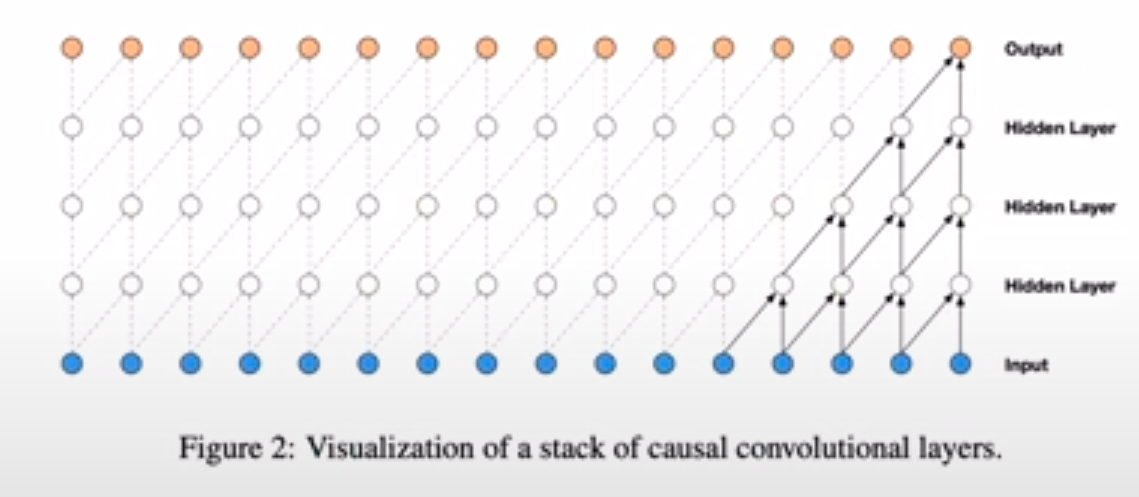

* We will implement this architecture:

  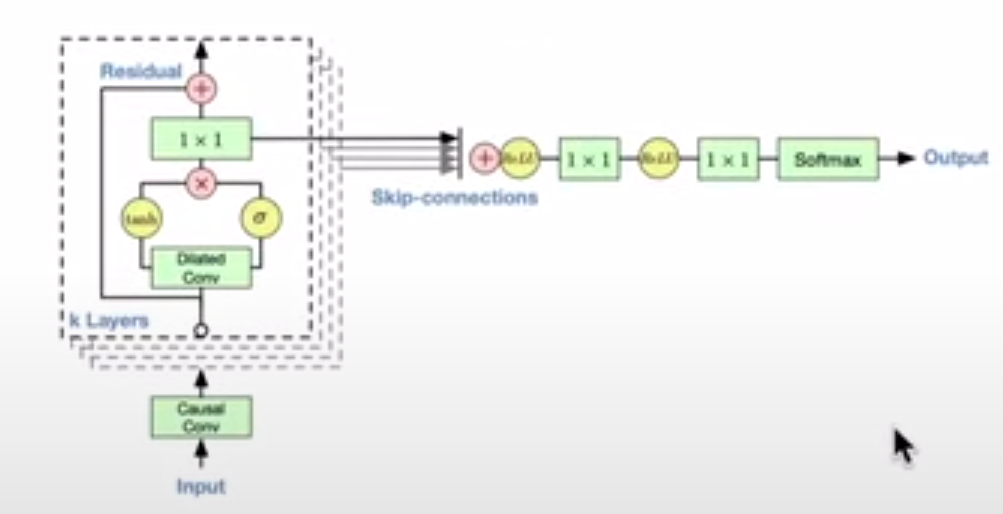


## Architecture Setup
* The starting code for this part is very similar to what we ended up in part 3

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# build vocab dicts
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [3]:
# shuffle words and build dataset
import random
random.seed(42)
random.shuffle(words)

block_size = 3

def build_dataset(words):
    X, Y = [],[]

    for w in words:
        context = [0] * block_size        
        for c in w+'.':
            X.append(context)
            xi = stoi[c]
            Y.append(xi)
            context = context[1:] + [xi]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [61]:
# NN classes
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
        self.bias = torch.randn((fan_out)) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
            with torch.no_grad():
                self.running_mean = (1.0-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1.0-self.momentum) * self.running_var + self.momentum * xvar
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = x * self.gamma * x + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


        
        

In [5]:
torch.manual_seed(42)

In [6]:
n_embd = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [7]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Get a batch to work on
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    # Expand embeddings and concat
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)    
    # Push embedding through layers
    for layer in layers:
        x = layer(x)
    # calculate loss (cross entropy)
    loss = F.cross_entropy(x, Yb)
    # call backwards
    for p in parameters:
        p.grad = None
    loss.backward()
    # Step into gradient direction with learning rate decay at 100000
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data -= p.grad * lr
    if i%10000 == 0:
        print(f'steps {i:7d}/{max_steps}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

steps       0/200000: 3.5904
steps   10000/200000: 2.1704
steps   20000/200000: 2.1057
steps   30000/200000: 2.1011
steps   40000/200000: 2.4548
steps   50000/200000: 1.9169
steps   60000/200000: 1.6128
steps   70000/200000: 2.2366
steps   80000/200000: 2.0602
steps   90000/200000: 2.1126
steps  100000/200000: 2.2566
steps  110000/200000: 2.1462
steps  120000/200000: 1.8469
steps  130000/200000: 2.1478
steps  140000/200000: 2.4995
steps  150000/200000: 2.1136
steps  160000/200000: 1.9335
steps  170000/200000: 1.8530
steps  180000/200000: 1.8397
steps  190000/200000: 1.6641


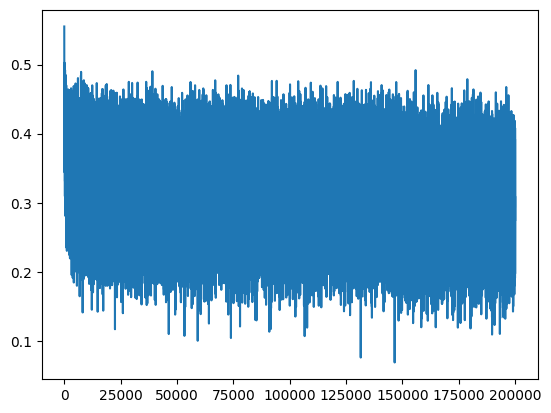

In [8]:
plt.plot(lossi)

In [10]:
# put layers in eval mode
for layer in layers:
    layer.training = False

In [11]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xtest, Ytest),
    }[split]
    emb = C[x]
    x = emb.view(x.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(f'{split}: {loss.item()}')
split_loss('train')
split_loss('val')

train: 2.025534152984619
val: 2.0999228954315186


In [12]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

jastiegoe.
caqiania.
braydent.
grachiza.
jah.
grance.
eydana.
alana.
benjarabeth.
milia.
ianner.
tivo.
dia.
becridlee.
reidhancy.
jeni.
jed.
kimmaddhira.
annea.
jamadyia.


## Fix Loss Plot

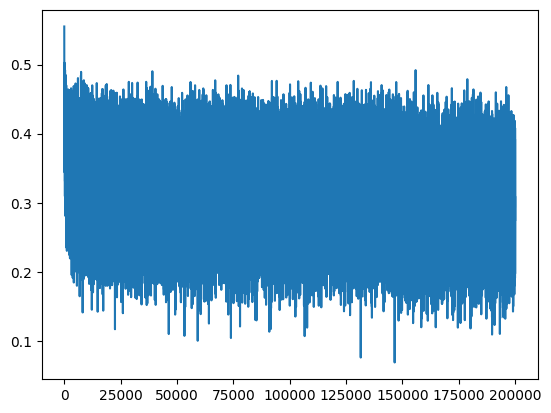

In [13]:
plt.plot(lossi)

* The reason for the spread is that the loss at each step depends on the batch, which is chosen randomly
* We can average out the losses to see the loss development during training more clearly

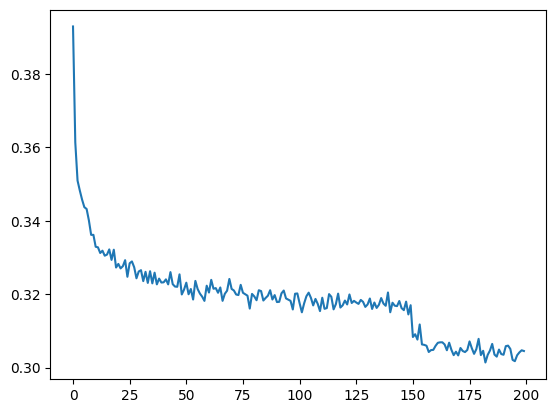

In [14]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

* The sudden drop of the loss at the 150th mean is because of the learning rate decay, because energy is taken out of the system to allow optimizing for the local minimum

## Torchify the Code
* We will adjust our code such that it follows torch's structure
* This will make the code more legible

### Convert all Forward Operations to Layer Classes
* Some operations in the forward pass are not layers for no good reason
* We will add Layer classes for the embedding ```C``` and the concatenation operation ```emb.view()```, which we will call "flattening" operation

In [9]:
class Embedding:
    def __init__(self, vocab_size, n_embd):
        self.weight = torch.randn((vocab_size, n_embd))

    def __call__(self, x):
        self.out = self.weight[x]
        return self.out

    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self, emb):
        self.out = emb.view(emb.shape[0], -1)
        return self.out

    def parameters(self):
        return []
        

* Now we can simplify parameter initialization and training

In [20]:
n_embd = 10
n_hidden = 200

layers = [
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), 
    BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [21]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Get a batch to work on
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    # Push embedding through layers
    x = Xb
    for layer in layers:
        x = layer(x)
    # calculate loss (cross entropy)
    loss = F.cross_entropy(x, Yb)
    # call backwards
    for p in parameters:
        p.grad = None
    loss.backward()
    # Step into gradient direction with learning rate decay at 100000
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data -= p.grad * lr
    if i%10000 == 0:
        print(f'steps {i:7d}/{max_steps}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

steps       0/200000: 3.3982
steps   10000/200000: 2.1404
steps   20000/200000: 2.1725
steps   30000/200000: 2.0674
steps   40000/200000: 1.8781
steps   50000/200000: 2.1414
steps   60000/200000: 1.9256


KeyboardInterrupt: 

### PyTorch Containers
* To simplify the code even further, we introduce the concept of pytorch containers
* Containers are a way of organizing layers into lists or dicts and so on
* In particular there is ```torch.NN.Sequential```, which maintains a list of layers

In [22]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

* So we can simplify further

In [30]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), 
    BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [31]:
def train_torchified():
    
    max_steps = 200000
    batch_size = 32
    lossi = []
    
    for i in range(max_steps):
        # Get a batch to work on
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix]
        # Push embedding through layers
        logits = model(Xb)
        # calculate loss (cross entropy)
        loss = F.cross_entropy(logits, Yb)
        # call backwards
        for p in model.parameters():
            p.grad = None
        loss.backward()
        # Step into gradient direction with learning rate decay at 100000
        lr = 0.1 if i < 150000 else 0.01
        for p in parameters:
            p.data -= p.grad * lr
        if i%10000 == 0:
            print(f'steps {i:7d}/{max_steps}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

In [32]:
train_torchified()

steps       0/200000: 4.0440
steps   10000/200000: 2.2949
steps   20000/200000: 2.0174
steps   30000/200000: 2.2716
steps   40000/200000: 2.3708
steps   50000/200000: 2.0535
steps   60000/200000: 1.7694
steps   70000/200000: 2.4316
steps   80000/200000: 1.8315
steps   90000/200000: 1.9100
steps  100000/200000: 1.8096
steps  110000/200000: 1.6568
steps  120000/200000: 2.2089
steps  130000/200000: 2.2392
steps  140000/200000: 2.0227
steps  150000/200000: 2.1328
steps  160000/200000: 2.0684
steps  170000/200000: 2.1297
steps  180000/200000: 2.1361
steps  190000/200000: 1.8784


In [29]:
# put layers in eval mode
for layer in model.layers:
    layer.training = False

In [28]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    for layer in model.layers:
        layer.training = False
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xtest, Ytest),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f'{split}: {loss.item()}')
split_loss('train')
split_loss('val')

train: 3.8371050357818604
val: 3.839674711227417


In [33]:
# sample form the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = torch.softmax(logits, 1)
        ix = torch.multinomial(probs, 1).item()
        out.append(ix)
        if ix == 0:
            break
        context = context[1:] + [ix]
    print(''.join([itos[c] for c in out]))

aveen.
arma.
neminiyah.
poilo.
hona.
samair.
hunee.
raysaboiro.
emma.
char.
micarlot.
ago.
aubrie.
reheot.
jette.
zairaan.
salea.
brah.
georgo.
jaylannie.


## Wavenet-like Architecture
* Our current losses are

In [34]:
split_loss('train')
split_loss('val')

train: 2.025728225708008
val: 2.100384473800659


* Because these losses are very similar to each other, we have a sense that we are not overfitting to the training set too much
* Thus, we can make additional progress in our performance by scaling up the size of the NN, by making everything bigger and deeper
* Our current architecture looks as follows
  
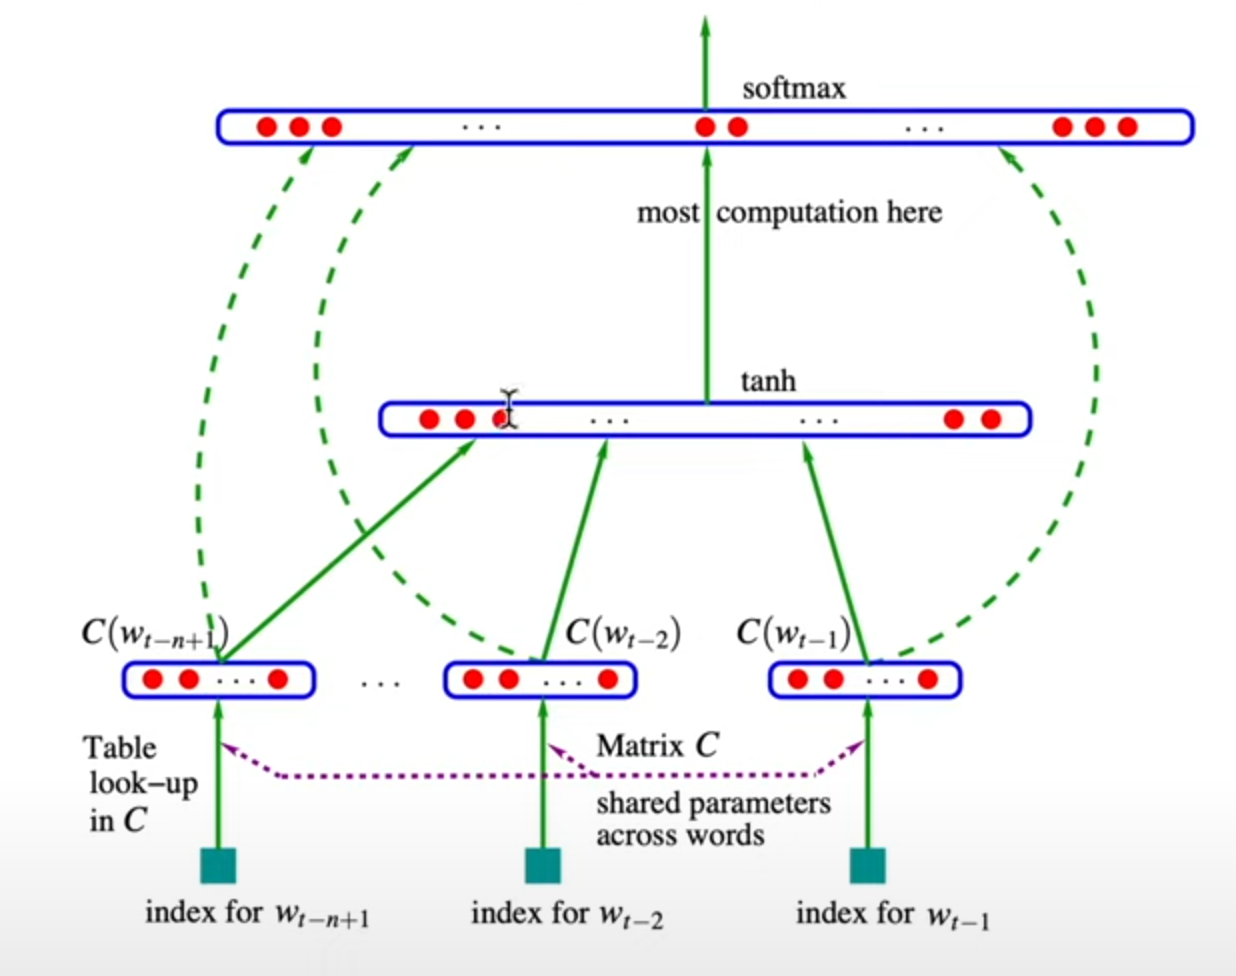

* Here we take a number of characters, go into a single hidden layer and then predict the next character
* The problem is, we don't have a naive way of making this bigger in a productive way
* We could  of course make the architecture deeper or make the hidden layer wider, but it would still crush all characters into one layer in a single step
* We want our architecture to look more like the wavenet architecture

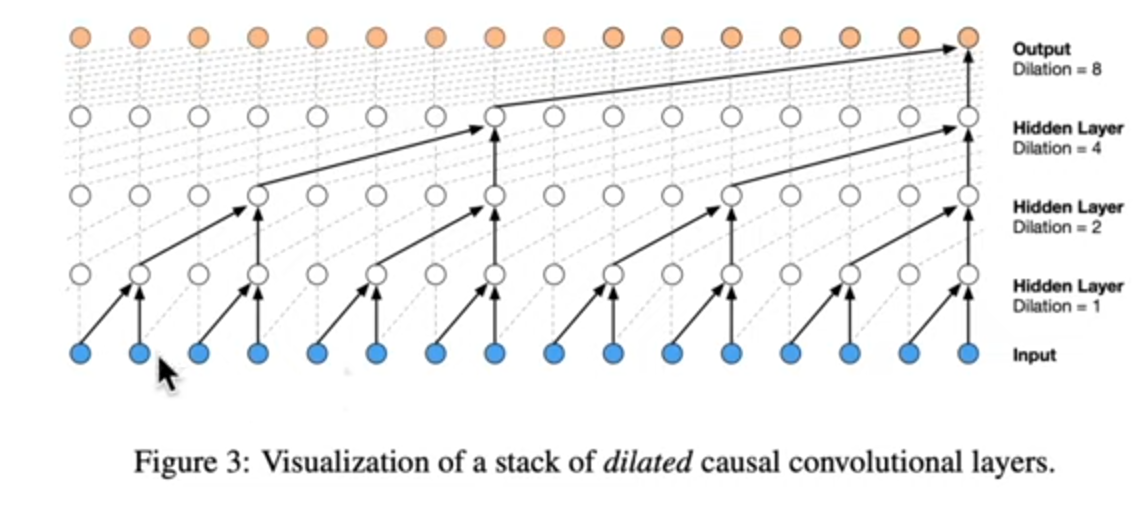

* The next character is a function of all the preceeding characters, but not all characters are crushed into a single layer, but are crushed slowly
* In particular we take two characters and sort of fuse them into a bigram representation, for all characters consecutively
* Then we take the bigrams and fuse those into four character level chunks and then we fuse that again
* We do this in a tree-like hierarchical manner, so we fuse the information from the previous context slowly into the network as it gets deeper

### Extending the Context Length

In [41]:
# shuffle words and build dataset
import random
random.seed(42)
random.shuffle(words)

block_size = 8                                # Change the number of input characters to 8

def build_dataset(words):
    X, Y = [],[]

    for w in words:
        context = [0] * block_size        
        for c in w+'.':
            X.append(context)
            xi = stoi[c]
            Y.append(xi)
            context = context[1:] + [xi]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [42]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> e
.......e ---> l
......el ---> i
.....eli ---> a
....elia ---> n
...elian ---> y
..eliany ---> s
.elianys ---> .
........ ---> t
.......t ---> r
......tr ---> o
.....tro ---> y
....troy ---> .
........ ---> m
.......m ---> a
......ma ---> r
.....mar ---> k
....mark ---> u
...marku ---> s
..markus ---> .


* The model initialization is unchanged, but the number of parameters has increased by 10000, because the block_size is larger

In [43]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), 
    BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


* Also training can take place unchanged
* We are still crushing all 8 characters into one hidden layer, but this will still improve performance

In [44]:
train_torchified()

steps       0/200000: 4.5038
steps   10000/200000: 2.3248
steps   20000/200000: 2.3029
steps   30000/200000: 2.1507
steps   40000/200000: 2.1612
steps   50000/200000: 2.1809
steps   60000/200000: 1.7914
steps   70000/200000: 1.8455
steps   80000/200000: 1.6729
steps   90000/200000: 2.0552
steps  100000/200000: 2.0886
steps  110000/200000: 1.6606
steps  120000/200000: 2.0004
steps  130000/200000: 1.5248
steps  140000/200000: 1.8107
steps  150000/200000: 1.7416
steps  160000/200000: 2.2306
steps  170000/200000: 2.0236
steps  180000/200000: 2.0943
steps  190000/200000: 2.0156


In [45]:
split_loss('train')
split_loss('val')

train: 1.876462459564209
val: 2.0366384983062744


* the validation loss improved by simply extending the context length
* when we sample from the model, we see the names improving qualitatively as well

In [40]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = torch.softmax(logits, dim=1)
        xi = torch.multinomial(probs, 1)
        out.append(xi.item())
        context = context[1:] + [xi]
        if xi == 0:
            break
    print(''.join([itos[c] for c in out]))
        
    
        
        

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x80 and 30x200)

* there is still a lot of optimization of hyperparameters left on the table, even with this simple model
* but we'll treat this as a baseline for the more complex model that we are now going to implement

|Context Length | Hidden Neurons | No. of Parameters | Training Loss | Validation Loss |
|---------------|----------------|-------------------|---------------|-----------------|
| 3 characters  | 200            | 12k               | 2.058         | 2.105           |
| 8 characters  | 200            | 22k               | 1.918         | 2.027           |

### Forward Pass: Inspecting the Shape of Tensors
* We'll start with 4 samples in a batch and the context length of 8

In [41]:
ix = torch.randint(0 , Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  2,  1],
        [ 0,  0,  8,  5, 26, 18, 15, 14],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0, 14,  1, 26,  1, 14]])

* As expected, we have 4 rows with 8 characters each and the integer tensors just contain the identity of those characters
* The first layer of our NN is the Embedding layer, so passing this integer tensor through the embedding layer expands each character identity to it's embedding representation, which is 10-dimensional

In [42]:
model.layers[0].out.shape

torch.Size([4, 8, 10])

* Next comes the Flattening layer that views the 4 by 8 by 10 tensor as a 4 by 80 tensor

In [43]:
model.layers[1].out.shape

torch.Size([4, 80])

* the linear layer takes 80 and creates 200 channels just via matrix multiplication

In [44]:
model.layers[2].out.shape

torch.Size([4, 200])

### Matrix Multiplication with n Dimensions

* And now something surprising
* Let's remind ourselves how the linear layer works
* It takes a 2d input and multiplies it with the 2d weights matrix and optionally adds a 1d bias
* So in terms of the shapes involved, it looks as follows:

In [45]:
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

* The surprising thing that one might not expect is that the input doesn't have to be 2d
* You can pass in higher dimensional tensors and everything works fine
* So the input could be 4 by 5 by 80

In [46]:
(torch.randn(4, 5, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 200])

* You can have as many dimensions as you like as input

In [47]:
(torch.randn(4, 5, 2, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 2, 200])

* The matrix multiplication will work on the last dimensions and the dimensions before that will be left unchanged
* So basically all these dimensions are treated as batch dimensions and the multiplication is done on the last dimension

### FlattenConsecutive
* We can use that in our network now
* Remember that we have these eight characters and we don't want to flatten all of them out into an eighty dimensional vector, because we don't want to matrix multiply 80 into a weight matrix multiply immediately
* instead we want to group these like this

```
(1 2) (3 4) (5 6) (7 8)
```

* so every consecutive two elements should be flattened out and multiplied by a weight matrix, but all of the four groups, we'd like to process in parallel
*  so it's kind of like a batch dimension that we can introduce and then we can in parallel process all of these bigram groups in the four batch dimensions of an individual example and also over the actual batch dimension of our 4 examples
*  This also changes how many dimensions come into the linear layer from 80 to 20, basically two characters fused
*  And the tensor that comes into the linear layer will be 4 by 4 by 20
*  This change needs to be done in the Flatten layer
*  We will use python indexing to do the grouping

In [48]:
list(range(10))[::2] # step size of 2 to get only the even parts

[0, 2, 4, 6, 8]

In [49]:
list(range(10))[1::2] # start at 1 and step size of 2 to get the odd parts

[1, 3, 5, 7, 9]

In [46]:
e = torch.randn(4, 8, 10)
e[:, ::2, :] # all batch elements and then even elements in the second dimension and all parts from last diemension
e[:, 1::2, :] # same only with odd characters
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2) # cat the even parts and the odd parts
print(explicit.size())

torch.Size([4, 4, 20])


* Again, using view is easier and more efficient
* We want to have groups of two in the last dimension and each embedding has size 10, so when grouping two elements, the size of the group needs to be 20
* For the 4 samples, we want groups of 20 for the last dimension
* Specifying the -1 will figure out how many groups

In [47]:
(e.view(4, -1, 20) == explicit).all()

tensor(True)

* Let's adjust Flatten to do this, but our Flatten diverges from pytorchs flatten, so we will also rename it

In [48]:
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, emb):
        B, T, C = emb.shape
        x = emb.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []



* and adjust our model to use the new class with flattening the whole block_size as we did before
* This should be equal to what we had before

In [107]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(block_size),
    Linear(n_embd * block_size, n_hidden, bias=False), 
    BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


In [108]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0, 13,  1, 20, 20,  8,  9,  1],
        [ 0,  0,  0,  0, 19,  1, 14,  4],
        [ 0,  0,  0,  0,  0, 22,  9,  3],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [109]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


### Hierarchichal Model

* To get the hierarchical pattern that we want, we flatten pairs of characters from the context
* naturally we have to adjust the model parameters

In [52]:
n_embd = 10
n_hidden = 200

ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),    
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    layers[-1].weight *= 0.1 # make the last layer less confident

logits = model(Xb)


In [53]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


* To compare the quality of this new architecture with the initial MLP architecture, we will configure the model to use 68 neurons in the hidden layer
* This will yield the same capacity for both models

In [54]:
n_embd = 10
n_hidden = 68


model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),    
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    layers[-1].weight *= 0.1 # make the last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


22397


In [89]:
train_torchified()

steps       0/200000: 3.3462
steps   10000/200000: 2.3472
steps   20000/200000: 1.8349
steps   30000/200000: 2.3512
steps   40000/200000: 2.1531
steps   50000/200000: 2.3354
steps   60000/200000: 1.6769
steps   70000/200000: 2.1003
steps   80000/200000: 1.9863
steps   90000/200000: 2.3259
steps  100000/200000: 1.9893
steps  110000/200000: 2.4921
steps  120000/200000: 1.7716
steps  130000/200000: 2.3254
steps  140000/200000: 1.6951
steps  150000/200000: 2.0944
steps  160000/200000: 1.7970
steps  170000/200000: 1.9384
steps  180000/200000: 1.7717
steps  190000/200000: 1.8022


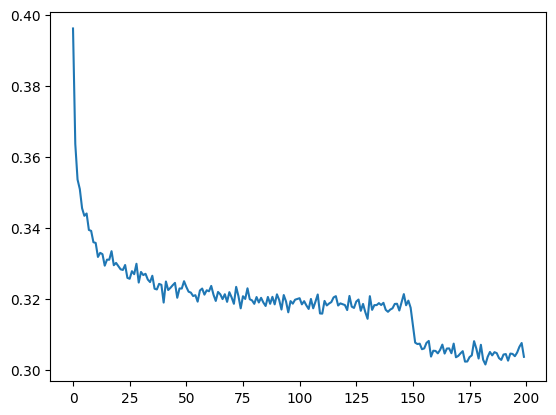

In [95]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [91]:
split_loss('train')
split_loss('val')

train: 1.8687772750854492
val: 2.05135178565979


|Model          | Hidden Neurons | No. of Parameters | Training Loss | Validation Loss |
|---------------|----------------|-------------------|---------------|-----------------|
| context: 3    | 200            | 12k               | 2.058         | 2.105           |
| context: 8    | 200            | 22k               | 1.918         | 2.027           |
| hierarchical  | 68             | 22k               | 1.868         | 2.051           |

* only going from flat to hierarchical didn't have much of an impact
* first, we didn't give much thought to the allocation of parameters to layers, so there is leeway for optimization
* secondly, there might be a bug in the BatchNorm1d layer that we have to inspect

### Debugging the BatchNorm1d Layer

* Let's inspect the shapes of the model after one iteration

In [55]:
ix = torch.randint(0, Xb.shape[0], (32,))
Xb = Xtr[ix]
logits = model(Xb)
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


* the BatchNorm1d layer receives the output from the linear layer, which is (32, 4, 68)
* if we look into the code of the BatchNorm1d layer, however, we see that it assumes a 2D input:
```python
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
```
* the mean and variance are calculated across the 0th dimension
* unfortunately, we don't get an error because everything broadcasts properly, but it doesn't do what we intended it to do
* let's isolate the code

In [63]:
e = torch.randn(32, 4, 68) # random tensor of the shape of FlattenConsecutive
emean = e.mean(0, keepdim=True)
evar = e.var(0, keepdim=True)
ehat = (e - emean) / torch.sqrt(evar + 1e-5)
ehat.shape

torch.Size([32, 4, 68])

In [64]:
model.layers[3].running_mean.shape

torch.Size([1, 4, 68])

* to calculate the mean and variance for each of the 68 neurons across all four batches, we specify a tuple as the dimension to reduce

In [65]:
e = torch.randn(32, 4, 68) # random tensor of the shape of FlattenConsecutive
emean = e.mean((0,1), keepdim=True)
evar = e.var((0,1), keepdim=True)
ehat = (e - emean) / torch.sqrt(evar + 1e-5)
ehat.shape

torch.Size([32, 4, 68])

In [66]:
emean.shape

torch.Size([1, 1, 68])

* let's fix the Batchnorm layer accrodingly

In [67]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
            with torch.no_grad():
                self.running_mean = (1.0-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1.0-self.momentum) * self.running_var + self.momentum * xvar
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = x * self.gamma * x + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


* to test this adjustment, we redefine the neural net and retrain
* the running mean should now be reduced to 1 in the first two dimensions

In [69]:
n_embd = 10
n_hidden = 68


model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),    
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    layers[-1].weight *= 0.1 # make the last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


22397


In [70]:
train_torchified()

steps       0/200000: 3.4863
steps   10000/200000: 1.6842
steps   20000/200000: 2.2167
steps   30000/200000: 2.0543
steps   40000/200000: 2.4715
steps   50000/200000: 1.9951
steps   60000/200000: 2.3176
steps   70000/200000: 1.9063
steps   80000/200000: 2.0644
steps   90000/200000: 1.8702
steps  100000/200000: 2.0805
steps  110000/200000: 1.9965
steps  120000/200000: 2.4008
steps  130000/200000: 2.1754
steps  140000/200000: 1.9569
steps  150000/200000: 2.6988
steps  160000/200000: 2.2304
steps  170000/200000: 1.8373
steps  180000/200000: 1.6622
steps  190000/200000: 1.7601


In [71]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

* validation performance

In [73]:
for layer in model.layers:
    layer.training = False

In [74]:
split_loss('train')
split_loss('val')

train: 1.8726730346679688
val: 2.040790319442749


* the validation performance improved a bit after our bugfix

|Model          | Hidden Neurons | No. of Parameters | Training Loss | Validation Loss |
|---------------|----------------|-------------------|---------------|-----------------|
| context: 3    | 200            | 12k               | 2.058         | 2.105           |
| context: 8    | 200            | 22k               | 1.918         | 2.027           |
| hierarchical  | 68             | 22k               | 1.868         | 2.051           |
| batchnorm fix | 68             | 22k               | 1.872         | 2.040           |